In [1]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


## Import necessary Libraries

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import csv
import random
import re
import os
import math
import time
import unicodedata
import codecs
from io import open
import itertools


import torch
import torch.nn as nn
import torch.optim as optim
from torch.jit import script, trace

import torchtext
from torchtext.data import Field, BucketIterator


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import pandas as pd

spacy_en = spacy.load('en')

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
#!pip uninstall torch -y
#!pip uninstall torchtext -y
#!pip install torch==1.7 torchtext==0.8.0

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
with open('gdrive/MyDrive/END/eng_to_python/program_qa_sep.py', 'r') as datafile:
    text = datafile.read()

## Create Source and Target data

In [6]:
questions = [x.split("\n")[0] for x in text.split('\n\n\n#')]

In [7]:
# Split question and answer

python_code = []

for i, code in enumerate(text.split('\n\n\n#')):
    try:
        python_code.append(code.split(questions[i]+"\n")[1].strip())
    except:
        print(i)
        print(code)
        python_code.append(" ")
        next

106
 write the list comprehension to pick out only negative integers from a
153
 write a python program to print only digit or only apha charac in a
1290
 44 write a python program to  rotate dictionary by K
1311
 64 write a program  to convert string to dictionary and print it
1548
 Python program to find whether a given number (accept from the user) is even or odd, print out an appropriate
1559
 Python program to print out all even numbers from a given numbers list in the same order and stop the printing if
1575
 Python program to create a list containing the power of said number in bases raised to the corresponding number in


## Clean the code by seperating special characters to reduce number of tokens

In [8]:

clean_code = []

for code in python_code:
  code = code.replace("(", " ( ")
  code = code.replace("[", " [ ")
  code = code.replace(":", " : ")
  code = code.replace(")", " ) ")
  code = code.replace(",", " , ")
  
  
  code = code.replace("]", " ] ")
  code = code.replace("}", " } ")
  code = code.replace("{", " { ")
  code = code.replace("=", " = ")
  code = code.replace("=  =", "==")
  code = code.replace("> =", ">=")
  code = code.replace("< =", "<=")
  code = code.replace("! =", "!=")
  code = code.replace("+ =", "+=")
  code = code.replace("- =", "-=")
  code = code.replace("* =", "*=")
  code = code.replace("/ =", "/=")
  code = code.replace("& =", "&=")
  # <
  code = code.replace("<", " < ")
  code = code.replace("< <", "<<")
  code = code.replace("< =", "<=")
  code = code.replace("< -", "<-")
  # -
  code = code.replace("-", " - ")
  code = code.replace("- =", "-=")
  code = code.replace("< -", "<-")
  # >
  code = code.replace(">", " > ")
  code = code.replace("> >", ">>")
  code = code.replace("> =", ">=")
  # !
  code = code.replace("!", " ! ")
  code = code.replace("! =", "!=")
  # +
  code = code.replace("+", " + ")
  code = code.replace("+ =", "+=")
  # *
  code = code.replace("*", " * ")
  code = code.replace("* *", "**")
  code = code.replace("* =", "*=")
  # /
  code = code.replace("/", " / ")
  code = code.replace("/ /", "//")
  code = code.replace("/ =", "/=")
  # &
  code = code.replace("&", " & ")
  code = code.replace("& =", "&=")
  code = code.replace("& &", "&&")
  # ~
  code = code.replace("~", " ~ ")
  # \n
  #code = code.replace("\n", " \n ")
  

  clean_code.append(code)



#clean_code = python_code

In [9]:
k = 988

questions[k], clean_code[k]

(' 56 Write a Python function to find three numbers from an array such that the sum of three numbers equal to zero.',
 'def three_Sum ( num )  : \n    if len ( num )  < 3 :  return  [  ] \n    num.sort (  ) \n    result =  [  ] \n    for i in range ( len ( num )  - 2 )  : \n        left = i + 1\n        right = len ( num )  - 1\n        if i != 0 and num [ i ]  == num [ i - 1 ]  : continue\n        while left < right : \n            if num [ left ]  + num [ right ]  ==  - num [ i ]  : \n                result.append (  [ num [ i ]  , num [ left ]  , num [ right ]  ]  ) \n                left = left + 1\n                right = right - 1\n                while num [ left ]  == num [ left - 1 ]  and left < right : left = left + 1\n                while num [ right ]  == num [ right + 1 ]  and left < right :  right = right - 1\n            elif num [ left ]  + num [ right ]  <- num [ i ]  : \n                left = left + 1\n            else : \n                right = right - 1\n    retu

## Define tokenizers and Field objects

In [10]:
def tokenize_en_char(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(" ".join([tok for tok in text]), )]

def tokenize_en_word(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text, )]


SRC = Field(tokenize = tokenize_en_word, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en_word, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = False, 
            batch_first = True)

fields = [('src',SRC), ('trg', TRG)]


/usr/local/lib/python3.7/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [11]:
example = [torchtext.data.Example.fromlist([questions[i], clean_code[i]], fields) for i in range(len(questions))] 
pyDataset = torchtext.data.Dataset(example, fields)
(train, valid, test) = pyDataset.split(split_ratio=[0.9, 0.07, 0.03], random_state=random.seed(SEED))
(len(train), len(valid), len(test))

/usr/local/lib/python3.7/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


(3920, 130, 305)

## Filter Dataset

In [15]:
MAX_SEQ_LEN = 256

MIN_SEQ_LEN = 10


for i in range(len(train.examples)):

  train_trg = vars(train.examples[i])['trg']

  if len(train_trg) > (MAX_SEQ_LEN - 2):
    del train.examples[i]
    i = 0

for i in range(len(test.examples)):

  test_trg = vars(test.examples[i])['trg']

  if len(test_trg) > (MAX_SEQ_LEN - 2):
    del test.examples[i]
    i = 0

for i in range(len(valid.examples)):

  val_trg = vars(valid.examples[i])['trg']

  if len(val_trg) > (MAX_SEQ_LEN - 2):
    del valid.examples[i]
    i = 0

(len(train), len(valid), len(test))

(3851, 129, 296)

In [16]:
vars(valid.examples[91])

{'src': [' ',
  'calculate',
  'memory',
  'is',
  'being',
  'used',
  'by',
  'an',
  'list',
  'in',
  'python'],
 'trg': ['import',
  'sys',
  '\n',
  'list1',
  ' ',
  '=',
  '  ',
  '[',
  "'",
  'Scott',
  "'",
  ',',
  ' ',
  "'",
  'Eric',
  "'",
  ',',
  ' ',
  "'",
  'Kelly',
  "'",
  ',',
  ' ',
  "'",
  'Emma',
  "'",
  ',',
  ' ',
  "'",
  'Smith',
  "'",
  ']',
  '\n',
  'print',
  '(',
  '"',
  'size',
  'of',
  'list',
  ' ',
  '=',
  ' ',
  '"',
  ',',
  'sys.getsizeof',
  '(',
  'list1',
  ')',
  ' ',
  ')']}

In [17]:
# Build vocabulary
SRC.build_vocab(pyDataset, min_freq = 2)
TRG.build_vocab(pyDataset, min_freq = 2)

In [18]:
len(SRC.vocab), len(TRG.vocab)

(1603, 5125)

In [19]:
vars(TRG.vocab)

{'freqs': Counter({'import': 734,
          'functools': 17,
          '\n': 5320,
          'os': 28,
          'from': 301,
          'time': 85,
          'localtime': 2,
          'threading': 5,
          'Thread': 9,
          'random': 141,
          're': 61,
          'itertools': 62,
          'json': 27,
          'datetime': 132,
          'date': 37,
          'num1': 282,
          ' ': 56202,
          '=': 13149,
          '1.5': 12,
          'num2': 266,
          '6.3': 11,
          'sum': 417,
          '+': 2673,
          'print': 3876,
          '(': 18525,
          "f'Sum": 9,
          ':': 11615,
          '  ': 5253,
          '{': 1418,
          '}': 1418,
          "'": 6708,
          ')': 18516,
          'def': 2605,
          'add_two_numbers': 5,
          ',': 13468,
          '\n    ': 5077,
          'return': 2523,
          '10': 581,
          '12': 213,
          'num3': 52,
          '14': 29,
          'if': 2123,
          '>': 884,
      

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [21]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
     (train, valid, test), 
     batch_size = BATCH_SIZE,
     sort_key=lambda x : len(x.src),
     sort_within_batch=False,
     device = device)

/usr/local/lib/python3.7/dist-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


# Create Model
___________________

In [22]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = MAX_SEQ_LEN):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src


class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src


class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention


class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x


class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = MAX_SEQ_LEN):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention


class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        # query, key, value
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention


class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [23]:
len(SRC.vocab), len(TRG.vocab)

(1603, 5125)

In [24]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 512
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 1024
DEC_PF_DIM = 1024
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [25]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [26]:
model

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(1603, 256)
    (pos_embedding): Embedding(256, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
     

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,124,229 trainable parameters


In [28]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [29]:
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(1603, 256)
    (pos_embedding): Embedding(256, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
     

In [30]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [31]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [32]:

def train(model, iterator, optimizer, criterion, clip):
    

    model.train()
    
    epoch_loss = 0

    errors = 1
    
    for i, batch in enumerate(iterator):
        

        src = batch.src
        trg = batch.trg
        #print(trg.shape)
        seq_len = trg.shape[1] -1 
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        #print(output.shape,trg.shape)    
        loss = criterion(output, trg)

        
        loss.backward()
      
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        epoch_loss += loss.item()/ seq_len

        optimizer.step()

        errors += 1

          
        
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg
            seq_len = trg.shape[1] -1

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()/seq_len
        
    return epoch_loss / len(iterator)

In [33]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [39]:
N_EPOCHS = 50
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'gdrive/MyDrive/END/eng_to_python/model1.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

/usr/local/lib/python3.7/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Time: 0m 15s
	Train Loss: 0.024 | Train PPL:   1.024
	 Val. Loss: 0.085 |  Val. PPL:   1.089
Epoch: 02 | Time: 0m 16s
	Train Loss: 0.017 | Train PPL:   1.017
	 Val. Loss: 0.069 |  Val. PPL:   1.071
Epoch: 03 | Time: 0m 15s
	Train Loss: 0.013 | Train PPL:   1.013
	 Val. Loss: 0.055 |  Val. PPL:   1.057
Epoch: 04 | Time: 0m 15s
	Train Loss: 0.012 | Train PPL:   1.012
	 Val. Loss: 0.046 |  Val. PPL:   1.047
Epoch: 05 | Time: 0m 15s
	Train Loss: 0.011 | Train PPL:   1.011
	 Val. Loss: 0.039 |  Val. PPL:   1.040
Epoch: 06 | Time: 0m 15s
	Train Loss: 0.010 | Train PPL:   1.010
	 Val. Loss: 0.034 |  Val. PPL:   1.035
Epoch: 07 | Time: 0m 15s
	Train Loss: 0.009 | Train PPL:   1.009
	 Val. Loss: 0.033 |  Val. PPL:   1.033
Epoch: 08 | Time: 0m 16s
	Train Loss: 0.008 | Train PPL:   1.008
	 Val. Loss: 0.029 |  Val. PPL:   1.029
Epoch: 09 | Time: 0m 15s
	Train Loss: 0.008 | Train PPL:   1.008
	 Val. Loss: 0.028 |  Val. PPL:   1.028
Epoch: 10 | Time: 0m 15s
	Train Loss: 0.007 | Train PPL

In [37]:
#torch.save(model.state_dict(), 'gdrive/MyDrive/END/eng_to_python/model1.pt')
#model.load_state_dict(torch.load('gdrive/MyDrive/END/eng_to_python/model1.pt'))

In [35]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 100):
    # For Prediction
  # Set the model in evaluation mode to deactivate the DropOut modules
  # This is IMPORTANT to have reproducible results during evaluation!
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        if i % 100 == 0: print(i)

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

## Randomly predict python code for 20 test samples

In [42]:
import random
samples = random.sample(range(100), 20)

for i in samples:
    src = vars(test.examples[i])['src']
    trg = vars(test.examples[i])['trg']
    print(" ".join(src))
    print(" ".join(trg))

    translation, attention = translate_sentence(src, SRC, TRG, model, device, max_len=256)
    
    print(f'\npredicted trg: \n', " ".join(translation))

    print("\n\n----------------------------------------------------------------------------------\n\n")



  write a python program to implement shell sort and print the sorted list for the below list
def gaps ( size )   : 
     length   =   size.bit_length (   ) 
     for k in range ( length   -   1 ,   0 ,    - 1 )   : 
         yield 2 *   * k   -   1 
 
 
 def shell_sort ( alist )   : 
     def insertion_sort_with_gap ( gap )   : 
         for i in range ( gap ,   len ( alist )   )   : 
             temp   =   alist [ i ] 
             j   =   i   -   gap 
             while   ( j   > =   0 and temp   <   alist [ j ]   )   : 
                 alist [ j   +   gap ]    =   alist [ j ] 
                 j   =   j   -   gap 
             alist [ j   +   gap ]    =   temp 
 
     for g in gaps ( len ( alist )   )   : 
         insertion_sort_with_gap ( g ) 
 
 
 alist   =    [ 2 ,   3 ,   5 ,   6 ,   4 ,   5 ] 
 shell_sort ( alist ) 
 print ( ' Sorted list :   ' ,   end = '' ) 
 print ( alist )
0
100
200

predicted trg: 
 def gaps ( size )   : 
     length   =   size.bit_length (   ) 
     f

In [39]:
def display_attention(sentence, translation, attention, n_heads = 4, n_rows = 2, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        # print('attn',attention.shape)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

0


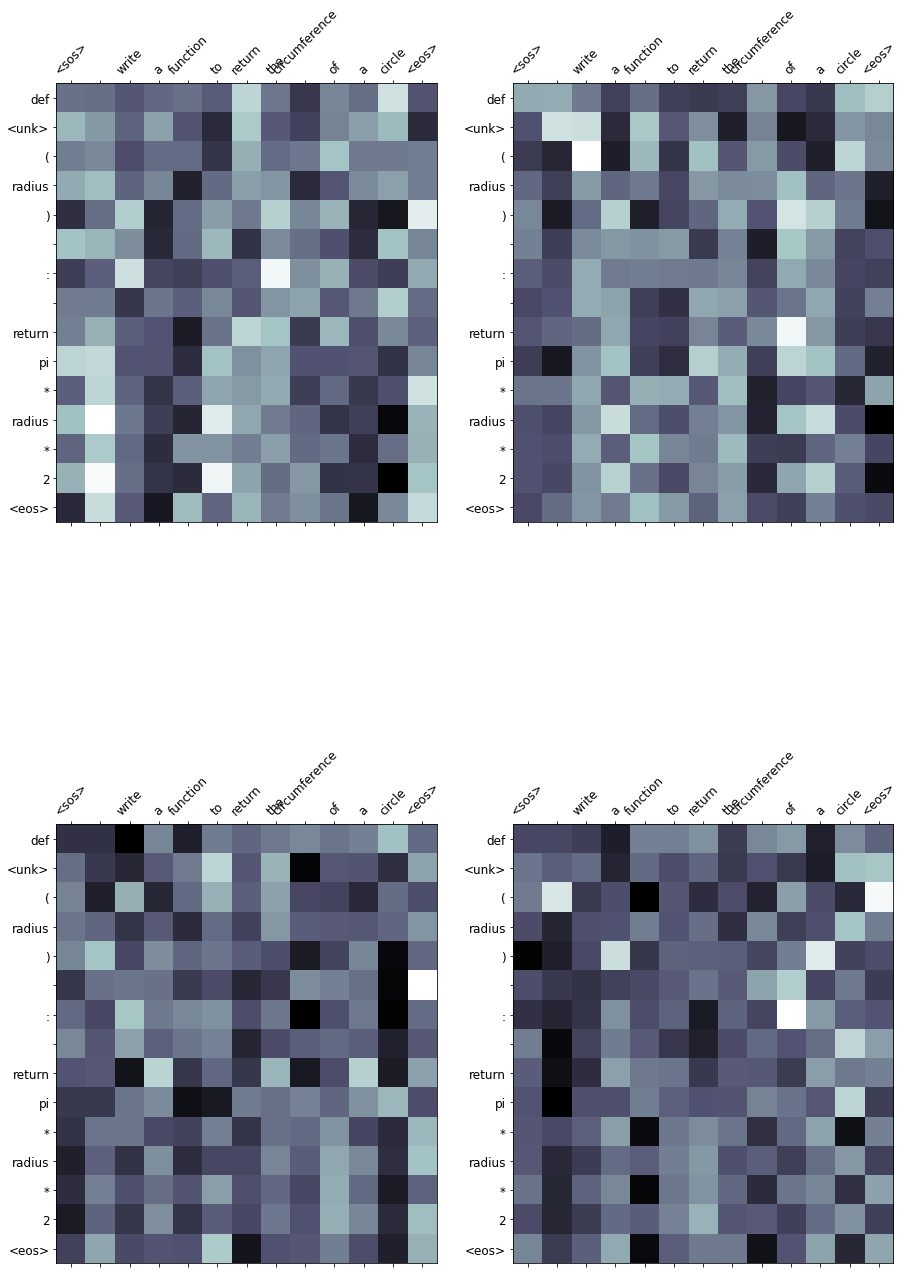

In [41]:
src = vars(test.examples[10])['src']
trg = vars(test.examples[10])['trg']

translation, attention = translate_sentence(src, SRC, TRG, model, device, max_len=256)
display_attention(src, translation, attention)